# Artificial Neural Networks vs. Physics-Informed Neural Networks

By Tabita Catalán, Tomás Banduc, David Ortiz y Francisco Sahli, 2025

Explore the foundational paper on PINNs [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).

### Introduction

Artificial Neural Networks (ANNs) are powerful tools for solving complex, data-driven tasks. However, they often require large amounts of data and may lack interpretability when dealing with physical systems. Physics-Informed Neural Networks (PINNs) address this by embedding known physical laws directly into the training process, making them especially useful for tasks where governing equations are available but data is limited. In this activity, we’ll explore both approaches by applying them to model the **oscillating pendulum**, a classic nonlinear system.

### Activity Overview

In this activity, we will code an Artificial Neural Network (ANN) and a Physics-Informed Neural Network (PINN) to solve the nonlinear mathematical model of an **oscillating pendulum**. This approach will highlight the benefits of integrating physical laws into the network's loss function.

### Activity Goals

By the end of this activity, you will be able to:

 - Understand the need for numerical solutions in complex models.
 - Recognize the advantages of Physics-Informed Neural Networks (PINNs) over traditional Artificial Neural Networks (ANNs).
 - Train data-driven PINNs using PyTorch.
 - Apply PINNs to solve nonlinear models.

## Mathematical description of the oscillating pendulum
We want to solve the mathematical problem related to the **oscillating pendulum** [(wiki)](https://en.wikipedia.org/wiki/Pendulum_(mechanics)):


| ![GIF](https://github.com/dortiz5/deep-learning-UV-PINN-curso/blob/main/data/figures/Oscillating_pendulum.gif?raw=1) | <img src="https://github.com/dortiz5/deep-learning-UV-PINN-curso/blob/main/data/figures/Pendulum_gravity.svg?raw=1" alt="Diagrama del proyecto" width="300"/> |
|-------------------------------------------|-------------------------------------------|
| Pendulum velocity and acceleration vectors  | Force diagram |


Assumptions:
- The rod is rigid and massless [(Homework - case of elastic string)](https://en.wikipedia.org/wiki/Elastic_pendulum#:~:text=In%20physics%20and%20mathematics%2C%20in,%2Ddimensional%20spring%2Dmass%20system.).
- The weight is a point mass.
- Two dimensions [(Homework - additional dimension for motion)](https://www.instagram.com/reel/CffUr64PjCx/?igsh=MWlmM2FscG9oYnp6bw%3D%3D).
- No air resistance [(Homework - immersion on a fluid)](https://www.youtube.com/watch?v=erveOJD_qv4&ab_channel=Lettherebemath).
- Gravitational field is uniform and the support does not move.

We are interested in find the vertical angle $\theta(t) \in [0, 2\pi)$ such that:

$$
\frac{d^2\theta}{dt^2}+\frac{g}{l}\sin\theta=0,\quad\theta(0)=\theta_0,\quad\theta'(0)=0,\quad t\in\mathbb{R},
$$

where $g\approx 9.81[m/s^2]$, $l$ is the length of the rod and $t$ the temporal variable.

Review on differential equations:
- Why is this a non-linear differential equation? What assumption could be included to linearize the model?
- It is an ordinary differential equation (ODE) or a partial differential equation (PDE)?
- Which is the order? Which is the degree?

A usefull method is to convert the model to a coupled system of ODEs:

$$
\begin{align*}
\frac{d\theta}{dt} &= \omega, \quad \text{(angular velocity)}\\
\frac{d\omega}{dt} & = -\frac{g}{l}\sin\theta, \quad \text{(angular acceleration)}
\end{align*}
$$

## Workflow
1. Calculate the numerical solution of the oscillating pendulum non-linear model.
2. Prepare the training data by adding noise, resample, and cutting the time to simulate a real escenario.
3. Define the ANN model using PyTorch arquitecture and train using the prepared data. Plot the solution.
4. Define the PINN model using PyTorch arquitecture and train using the prepared data. Plot the solution.
5. Compare the solutions obtained from both architectures.


### Initial setup

We begin by importing some usefull packages, and defining some functions

In [ ]:
%matplotlib inline

In [ ]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mlp
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Actualización de los parámetros de Matplotlib
gray = '#5c5c5c' #'#5c5c5c' '000'
mlp.rcParams.update(
    {
        "image.cmap" : 'viridis', # plasma, inferno, magma, cividis
        "text.color" : gray,
        "xtick.color" :gray,
        "ytick.color" :gray,
        "axes.labelcolor" : gray,
        "axes.edgecolor" :gray,
        "axes.spines.right" : False,
        "axes.spines.top" : False,
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,

        'font.size' : 15,
        'interactive': False,
        "font.family": 'sans-serif',
        "legend.loc" : 'best',
        'text.usetex': False,
        'mathtext.fontset': 'stix',
    }
)

# Util function to calculate the signal-to-noise ratio
def calculate_snr(signal, noise):
    # Ensure numpy arrays
    signal, noise = np.array(signal), np.array(noise)

    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)

    # Calculate the SNR in decibels (dB)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Util function to calculate the relative l2 error
def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.norm(u_num - u_ref, p=2)

    # Calculate the L2 norm of the reference
    l2_ref = torch.norm(u_ref, p=2)

    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2

# Util function to plot the solutions
def plot_comparison(time, theta_true, theta_pred, loss):

    # Convert tensors to numpy arrays for plotting
    t_np = time.detach().cpu().data.numpy()
    theta_pred_np = theta_pred.detach().cpu().data.numpy()

    # Create a figure with 2 subplots
    _, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the true and predicted values
    axs[0].plot(t_np, theta_true, label = r'$\theta(t)$ (numerical solution)')
    axs[0].plot(t_np, theta_pred_np, label = r'$\theta_{pred}(t)$ (predicted solution) ')
    axs[0].set_title('Angular displacement Numerical Vs. Predicted')
    axs[0].set_xlabel(r'Time $(s)$')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_ylim(-1,1.3)
    axs[0].legend(loc='best', frameon=False)


    # Plot the difference between the predicted and true values
    difference = np.abs(theta_true.reshape(-1,1) - theta_pred_np.reshape(-1,1))
    axs[1].plot(t_np, difference)
    axs[1].set_title('Absolute Difference')
    axs[1].set_xlabel(r'Time $(s)$')
    axs[1].set_ylabel(r'$|\theta(t) - \theta_{pred}(t)|$')
    # Display the plot
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    plt.show()

    # Plot the loss values recorded during training
    # Create a figure with 1 subplots
    _, axs = plt.subplots(1, 1, figsize=(6, 3))
    axs.plot(loss)
    axs.set_xlabel('Iteration')
    axs.set_ylabel('Loss')
    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_title('Training Progress')
    axs.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Util function to calculate tensor gradients with autodiff
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect
    to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                        grad_outputs=torch.ones_like(outputs),
                        create_graph=True,
                        )[0]

Using cpu device



## 1. Numerical solution of the oscillating pendulum
For the numerical solution we use the [Runge-Kutta of forth order](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) from `scipy`. We begin by defining the parameters for this example, the pendulum model, and the domain:

In [ ]:
g = 9.81  # gravity acceleration (m/s^2)
L = 1.0   # Pendulum's rod length (m)
theta0 = np.pi / 4  # Initial condition (Position in rads)
omega0 = 0.0        # Initial angular speed (rad/s)
sample_freq = 100   # sample rate 100Hz

# Simulation time
t_span = (0, 10)  # from 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], sample_freq*t_span[1])  # Points to be evaluated

# We define the system of coupled ODEs
def pendulum(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Initial conditions
y0 = [theta0, omega0]

Now, we solve the problem numerically using `scipy`

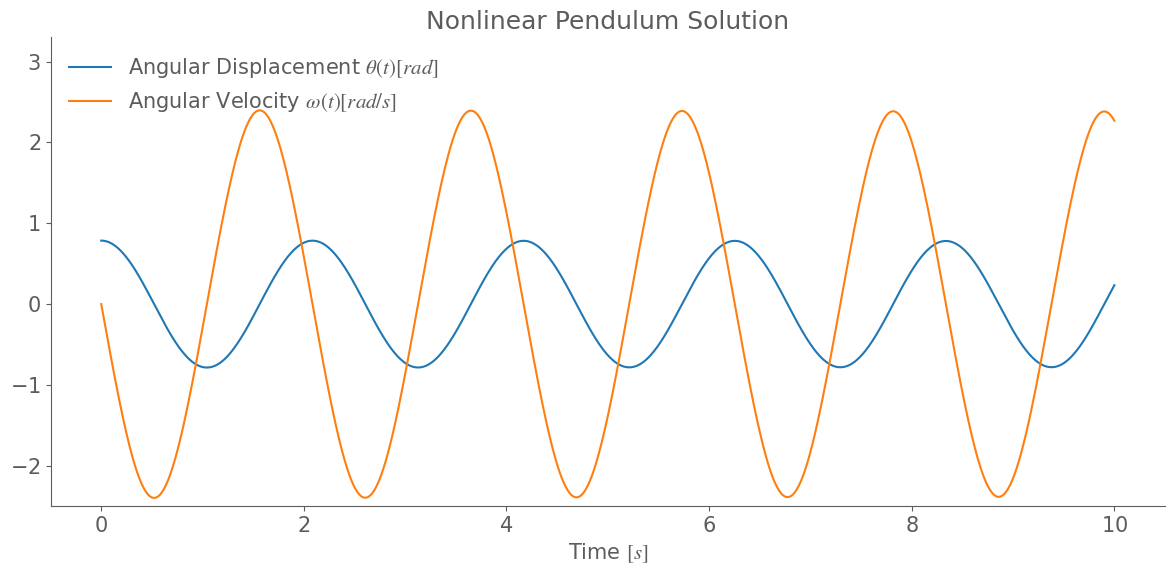

In [ ]:
from scipy.integrate import solve_ivp

# Solve the initial value problem using Runge-Kutta 4th order
num_sol = solve_ivp(pendulum, t_span, y0, t_eval=t_eval, method='RK45')

# We extract the solutions
theta_num = num_sol.y[0]
omega_num = num_sol.y[1]

# We graph the results
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta_num, label=r'Angular Displacement $\theta(t)[rad]$')
plt.plot(t_eval, omega_num, label=r'Angular Velocity $\omega(t)[rad/s]$')
plt.xlabel(r'Time $[s]$')
plt.ylim(-2.5,3.3)
plt.legend(loc='best', frameon=False)
plt.title('Nonlinear Pendulum Solution')
plt.grid(False)
plt.tight_layout()
plt.show()

## 2. Preparing the training data

In the following, we consider the numerical solution as the **training data** that comes from the measures of a sensor. We add gaussian noise, resample and cut the data to $2.5s$ to test the performance of the ANN, simulating a real scenario. Also, we calculate the signal-to-noise ratio $SNR = 10\log_{10} \left(\frac{P_{signal}}{P_{noise}}\right)$, where $P_{signal}$ and $P_{noise}$ are the power of the signal and the noise, respectively, to get the amount of distortion in the signal. Finally, we call the noisy training data $\theta_{data}(t)$.

SNR: 20.9563 dB


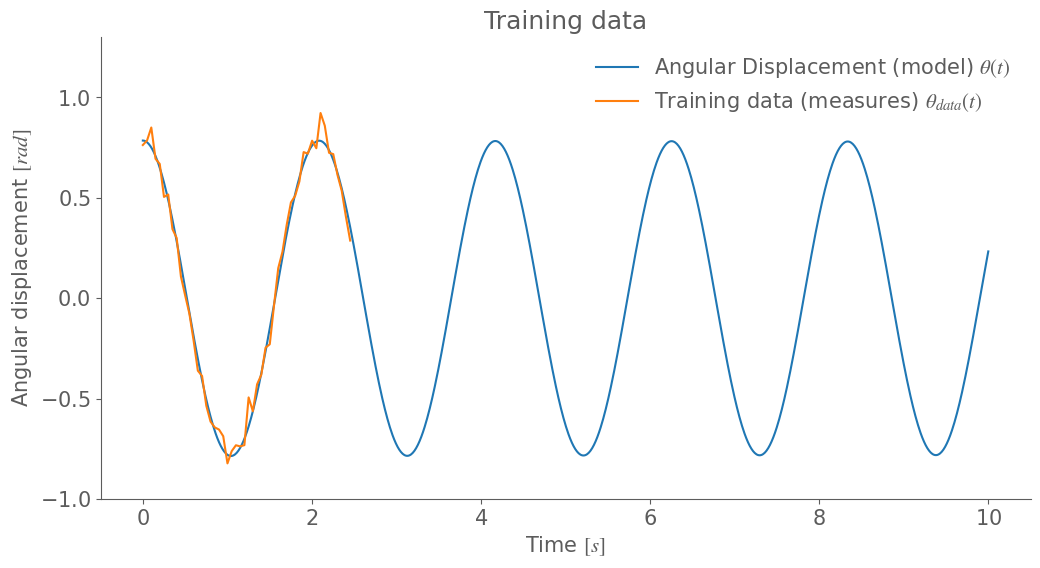

In [ ]:
# Add gaussian noise
std_deviation = 0.05
noise = np.random.normal(0,std_deviation,theta_num.shape[0])
theta_noisy = theta_num + noise
print(f'SNR: {calculate_snr(theta_noisy, noise):.4f} dB')

# Resample and cut to 2.5s
resample = 5          # resample
cut_time = int(2.5*sample_freq)  # 2.5s times 100Hz

theta_data = theta_noisy[:cut_time:resample]
t_data = t_eval[:cut_time:resample]

# We graph the observed data
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta_num, label=r'Angular Displacement (model) $\theta(t)$ ')
plt.plot(t_data, theta_data, label=r'Training data (measures) $\theta_{data}(t)$ ')
plt.xlabel(r'Time $[s]$')
plt.ylabel(r'Angular displacement $[rad]$')
plt.ylim(-1,1.3)
plt.legend(loc='best', frameon=False)
plt.title('Training data')
plt.grid(False)
plt.show()

## 3. Training the Artificial Neural Network

We train the artificial neural network to directly approximate the solution to the differential equation, i.e.,

$$
\theta_{NN}(t; \Theta) \approx \theta(t)
$$

where $\Theta$ are the free (trainable) parameters of the ANN. Now, we use `PyTorch` and define the neural network and, for this task, we will use the ADAM optimizer. Also, we convert the temporal domain and the observations to `torch.tensors`

In [ ]:
torch.manual_seed(123)

# training parameters
hidden_layers = [1, 20, 20, 20, 1]
learning_rate = 0.001
training_iter = 50000

In [ ]:
# Define a loss function (Mean Squared Error) for training the network
MSE_func = nn.MSELoss()

# Convert the NumPy arrays to PyTorch tensors and add an extra dimension
# test time Numpy array to Pytorch tensor
t_test = torch.tensor(t_eval, device=device, requires_grad=True).view(-1,1).float()
# train time Numpy array to Pytorch tensor
t_data = torch.tensor(t_data, device=device, requires_grad=True).view(-1,1).float()
# Numerical theta to test Numpy array to pytorch tensor
theta_test = torch.tensor(theta_num, device=device, requires_grad=True).view(-1,1).float()
# Numerical theta to train Numpy array to pytorch tensor
theta_data = torch.tensor(theta_data, device=device, requires_grad=True).view(-1,1).float()

# Define a neural network class with user defined layers and neurons
class NeuralNetwork(nn.Module):

    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()

        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))

        self.layers = nn.Sequential(*layers)
        self.init_params()

    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)


In [ ]:
# Create an instance of the neural network
theta_ann = NeuralNetwork(hidden_layers).to(device)
nparams = sum(p.numel() for p in theta_ann.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_ann.parameters(), lr=learning_rate,
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 901


### Loss function
To train the ANN, it is mandatory to define the loss function. To this end, we consider the noisy data $\theta_{data}(t)$ and use the mean squared error ($MSE$) over the colocation points (samples over the domain) $\{t_i\}_N$, i.e.,

$$
\mathcal{L}\left(\Theta\right) := \lambda_1 MSE\left(\theta_{NN}(t; \Theta), \theta_{data}(t)\right) = \frac{\lambda_1}{N}\sum_i (\theta_{NN}(t_i; \Theta) - \theta_{data}(t_i))^2
$$

where $\lambda_1\in\mathbb{R}^+$ is a positive (weigth) number, and $N$ is the number of samples. The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$


Now, we use `PyTorch` and define the neural network, the function loss and, for this task, we will use the ADAM optimizer. Also, we convert the temporal domain and the observations to `torch.tensors`

In [ ]:
def NeuralNetworkLoss(forward_pass, t, theta_data, lambda1 = 1):

    theta_nn = forward_pass(t)
    data_loss = lambda1 * MSE_func(theta_nn, theta_data)

    return  data_loss

# Initialize a list to store the loss values
loss_values_ann = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):

    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = NeuralNetworkLoss(theta_ann,
                             t_data,
                             theta_data)    # must be (1. nn output, 2. target)

    # Append the current loss value to the list
    loss_values_ann.append(loss.item())

    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")


Iteration 0: Loss 0.500755786895752
Iteration 1000: Loss 0.0025719385594129562
Iteration 2000: Loss 0.0019704322330653667
Iteration 3000: Loss 0.0018839208642020822
Iteration 4000: Loss 0.0018217453034594655
Iteration 5000: Loss 0.0017839077627286315
Iteration 6000: Loss 0.0017664438346400857
Iteration 7000: Loss 0.0017391317524015903
Iteration 8000: Loss 0.001632848521694541
Iteration 9000: Loss 0.0014678859151899815
Iteration 10000: Loss 0.001392631558701396
Iteration 11000: Loss 0.0013436462031677365
Iteration 12000: Loss 0.001228531007654965
Iteration 13000: Loss 0.001092954888008535
Iteration 14000: Loss 0.0010592788457870483
Iteration 15000: Loss 0.0010328369680792093
Iteration 16000: Loss 0.0010139549849554896
Iteration 17000: Loss 0.000981831457465887
Iteration 18000: Loss 0.0009234996396116912
Iteration 19000: Loss 0.0008618300198577344
Iteration 20000: Loss 0.0008261326584033668
Iteration 21000: Loss 0.0007995097548700869
Iteration 22000: Loss 0.0007661192212253809
Iteration 

and we plot the results

Relative error: 1.1147899627685547


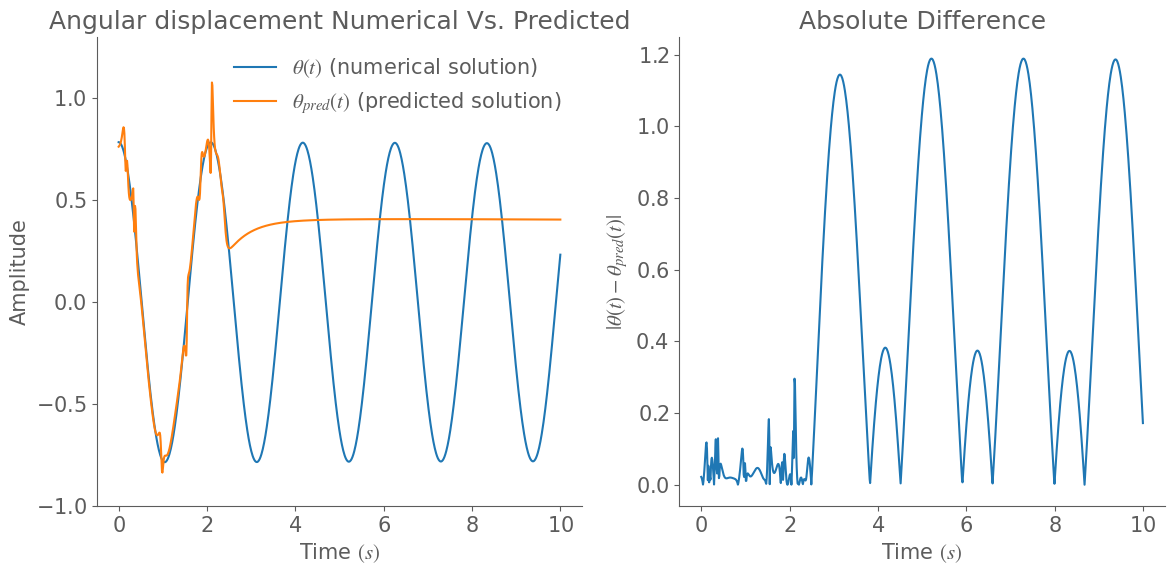

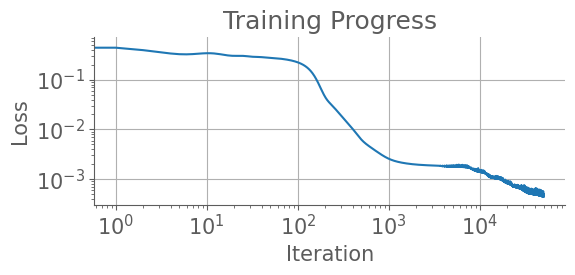

In [ ]:
theta_pred_ann = theta_ann(t_test).to(device)

print(f'Relative error: {relative_l2_error(theta_pred_ann, theta_test)}')

plot_comparison(t_test, theta_num, theta_pred_ann, loss_values_ann)

## 4. Training the Physics-Informed Neural Network
For this task we use the same noisy **training data** but in this case, we train the PINN to directly approximate the solution to the differential equation, i.e.,

$$
\theta_{PINN}(t; \Theta) \approx \theta(t)
$$

In [ ]:
# Create an instance of the neural network
theta_pinn = NeuralNetwork(hidden_layers).to(device)
nparams = sum(p.numel() for p in theta_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_pinn.parameters(), lr=learning_rate,
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 901


### Physics-Informed Loss function
To train the PINN, we recall the pendulum model and define function $f_{ode}(t;g,l)$, $g_{ic}(0)$ and $h_{bc}(0)$ for the ODE, the initial condition and the boundary condition. Also, we replace the analytical solution $\theta(t)$ with the PINN output $\theta_{pinn}(t; \Theta)$:

$$
\begin{align*}
f_{ode}(t;\theta_{pinn}):=&\frac{d^2\theta_{PINN}(t; \Theta)}{dt^2}+\frac{g}{l}\sin(\theta_{pinn}(t; \Theta)) = 0\\
g_{ic}(0;\theta_{pinn}):=&\theta_{pinn}(0; \Theta) = \theta_0\\
h_{bc}(0;\theta_{pinn}):=&\theta_{pinn}'(0; \Theta) = 0
\end{align*}
$$

Once again we use the $MSE$ and define the physics-informed loss function:

$$
\begin{align*}
\mathcal{L}(\theta):= &\frac{\lambda_1}{N}\sum_i\left(f_{ode}(t_i;\theta_{pinn})-0\right)^2 \quad \text{ODE loss}\\
                   & + \lambda_2 (g_{ic}(0;\theta_{pinn})-\theta_0)^2 \quad \text{IC loss}\\
                   & + \lambda_3 (h_{bc}(0;\theta_{pinn})-0)^2 \quad \text{BC loss}\\
                   & + \frac{\lambda_4}{N}\sum_i (\theta_{pinn}(t_i; \Theta) - \theta_{data}(t_i))^2 \quad \text{DATA loss}
\end{align*}
$$

where $\lambda_{1,2,3,4}\in\mathbb{R}^+$ are positive (weight) numbers, and $N$ is the number of samples.

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> when we do not include the loss function related to the data, we are employing a data-free scheme; when we include the data, we are employing a data-driven scheme.
</div>

The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> Autodifferentiation (torch.autograd) is a powerful tool for calculating the gradients of the PINN with respect to its input to evaluate the loss function; for more information, refer to the tutorial.
</div>



In [ ]:
# Define t = 0 for boundary an initial conditions
t0 = torch.tensor(0., device=device, requires_grad=True).view(-1,1)

# HINT: use grad funtion (a wraper for torch.autograd) to calculate the
# derivatives of the ANN
def PINNLoss(forward_pass, t_phys, t_data, theta_data,
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):

    # ANN output, first and second derivatives
    theta_pinn1 = forward_pass(t_phys)
    #TODO: calculate the first and second derivatives

    #TODO: calculate the ODE loss

    g_ic = forward_pass(t0)
    IC_loss = lambda2 * MSE_func(g_ic, torch.ones_like(g_ic)*theta0)

    #TODO: calculate boundary condition

    theta_nn2 = forward_pass(t_data)
    data_loss = lambda4 * MSE_func(theta_nn2, theta_data)

    return ODE_loss + IC_loss + BC_loss + data_loss

# Initialize a list to store the loss values
loss_values_pinn = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):

    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = PINNLoss(theta_pinn, t_test, t_data, theta_data)

    # Append the current loss value to the list
    loss_values_pinn.append(loss.item())

    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 14.915733337402344
Iteration 1000: Loss 0.6910970211029053
Iteration 2000: Loss 0.3467116057872772
Iteration 3000: Loss 0.29987984895706177
Iteration 4000: Loss 0.27331358194351196
Iteration 5000: Loss 0.2523644268512726
Iteration 6000: Loss 0.2377592772245407
Iteration 7000: Loss 0.21731987595558167
Iteration 8000: Loss 0.19626279175281525
Iteration 9000: Loss 0.1786472052335739
Iteration 10000: Loss 0.16392505168914795
Iteration 11000: Loss 0.15196622908115387
Iteration 12000: Loss 0.14299511909484863
Iteration 13000: Loss 0.15013790130615234
Iteration 14000: Loss 0.1393495798110962
Iteration 15000: Loss 0.13812318444252014
Iteration 16000: Loss 0.13879667222499847
Iteration 17000: Loss 0.13701994717121124
Iteration 18000: Loss 0.13600094616413116
Iteration 19000: Loss 0.13521680235862732
Iteration 20000: Loss 0.13443046808242798
Iteration 21000: Loss 0.1333489865064621
Iteration 22000: Loss 0.1314304620027542
Iteration 23000: Loss 0.12639598548412323
Iteration 2400

Once again, we plot the results

Relative error: 0.013331982307136059


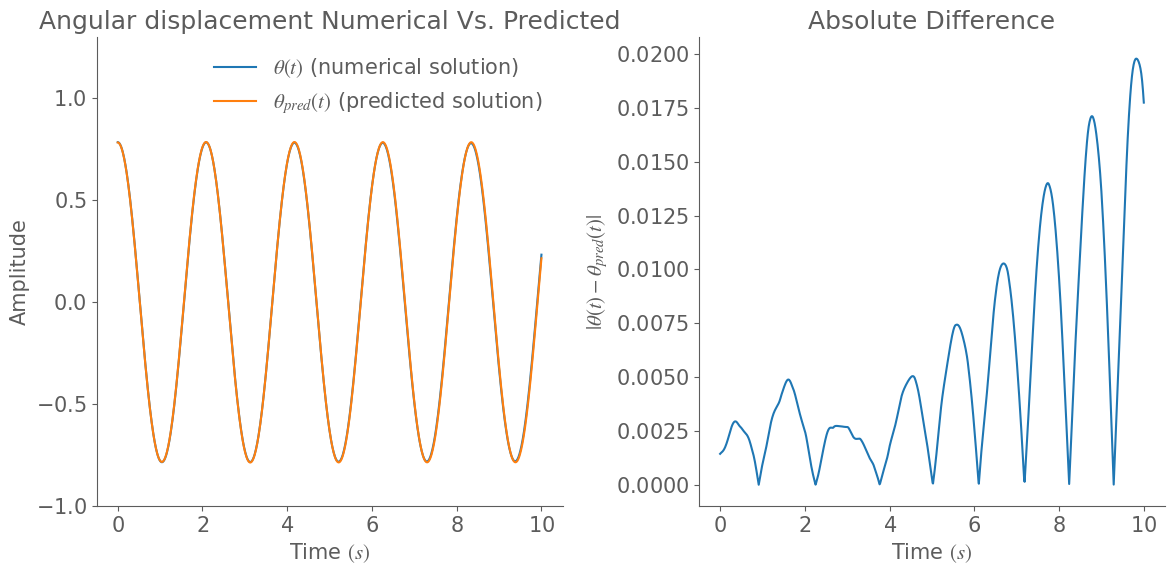

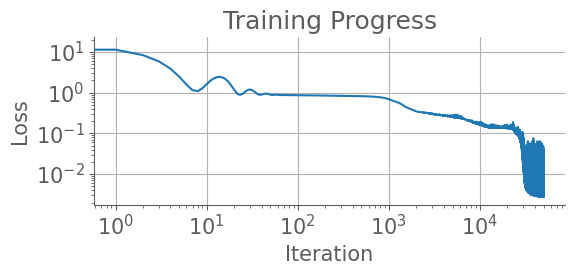

In [ ]:
theta_pred_pinn = theta_pinn(t_test)

print(f'Relative error: {relative_l2_error(theta_pred_pinn, theta_test)}')

plot_comparison(t_test, theta_num, theta_pred_pinn, loss_values_pinn)

## 5. Comparison

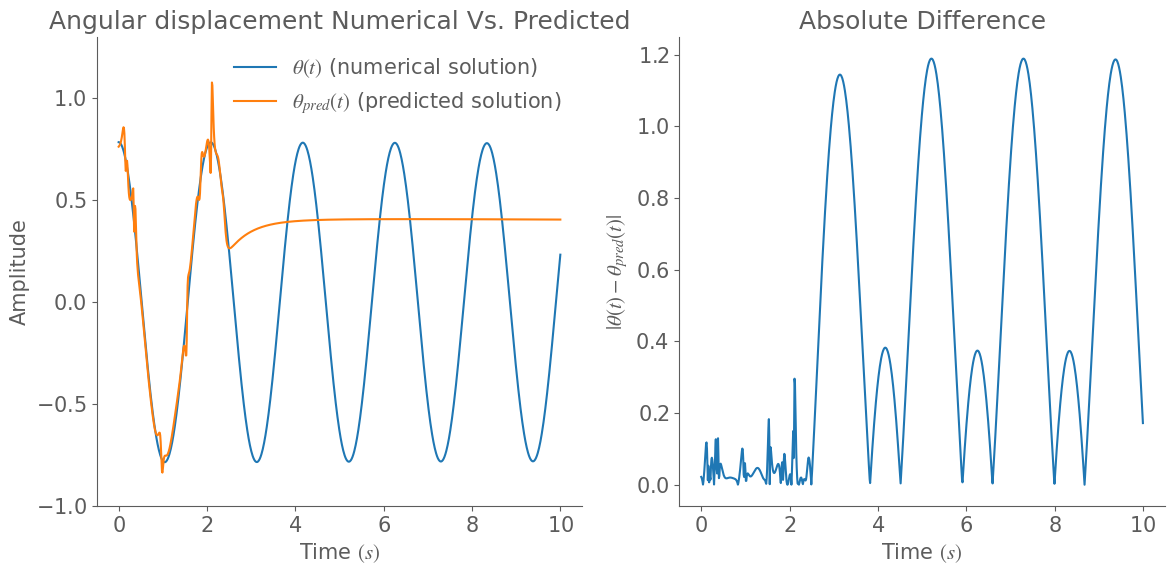

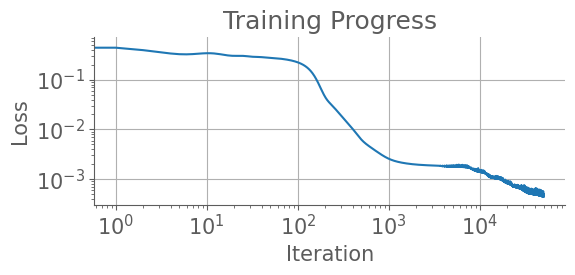

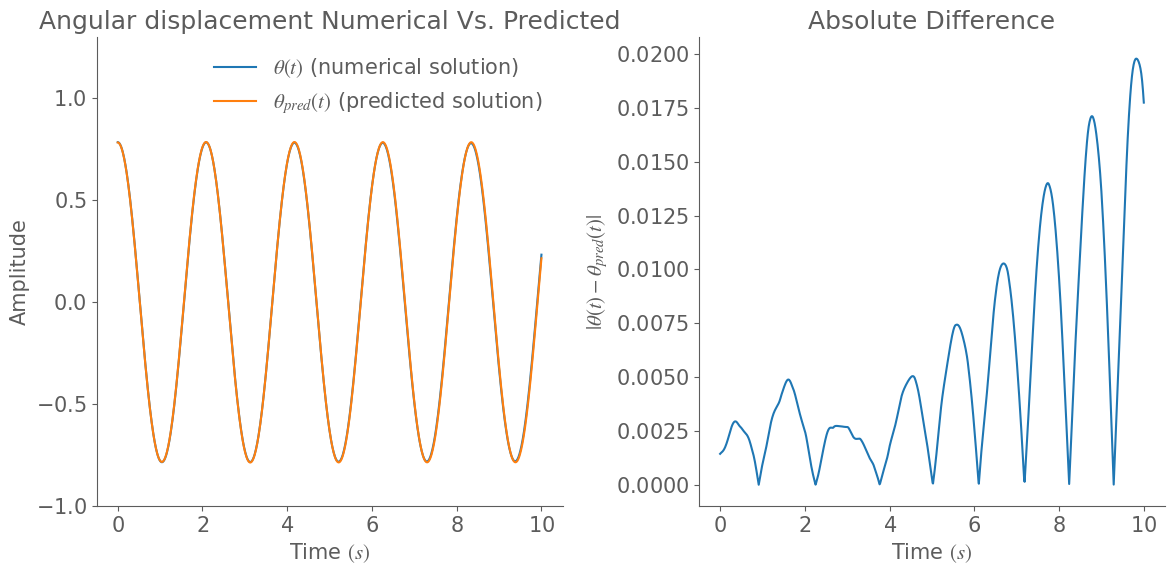

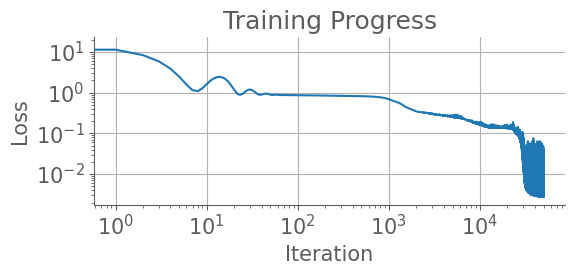

In [ ]:
plot_comparison(t_test, theta_num, theta_pred_ann, loss_values_ann)
plot_comparison(t_test, theta_num, theta_pred_pinn, loss_values_pinn)

## **Exercises**:
1. Try increasing and deacresing the `std_deviation` parameter in the [Preparing the training data](#Preparing-the-training-data) to change the `SNR`. Also, change the `resample` and the `ctime` variables to simulate other scenarios. Retrain the ANN and the PINN, and compare the results.
2. Increase and decrease the `lambdas` parameters of the loss function for both the ANN and the PINN.
3. Increase and reduce the learning rate of the optimizer, and the number of training iterations.
4. Change the number of hidden layers, the number of neurons, the activation functions of the NN model.

## **Questions**:
1. **How should overfitting be addressed in PINNs if the goal is to learn the underlying operators of the physical system?**  
   <details>
   <summary>Answer</summary>
   To be corrected
   </details>
   <!--When training PINNs to learn operators, overfitting occurs if the network memorizes specific training points (e.g., boundary or initial conditions) rather than capturing the general behavior of the operator across the domain. To address this, model regularization is essential—penalizing weight norms or implementing derivative-based regularization can help the network generalize. Expanding the training set to cover critical areas, adding controlled noise to training data, and carefully adjusting network complexity can further reduce overfitting. Monitoring the residual error across the domain also helps ensure the network learns the operator’s global behavior rather than memorizing specific patterns.


2. **What advantages does using MSE in the loss function offer, given that this approach may underestimate the solution by not incorporating integral or variational formulations?**  
   <details>
   <summary>Answer</summary>
   Using MSE as the loss function provides a straightforward and computationally efficient way to measure pointwise differences between the model predictions and target values. However, MSE focuses only on individual points, which may limit its capacity to capture the global behavior of the solution, particularly in complex domains. By incorporating integral or variational formulations, the loss function can reflect the solution’s behavior over the entire domain, potentially improving accuracy and stability. Despite these limitations, MSE remains popular because it simplifies implementation and reduces computational costs, making it suitable for many practical applications.
   </details>


3. **In what ways are PINNs advantageous compared to traditional numerical methods, considering the time required for training?**  
   <details>
   <summary>Answer</summary>
   PINNs offer several advantages over traditional numerical methods, despite their typically longer training times. One key advantage is their flexibility in handling complex, high-dimensional domains and irregular geometries without requiring structured grids. PINNs can also incorporate additional constraints or data seamlessly, such as experimental measurements or boundary conditions. Unlike many numerical methods, PINNs generalize well across different initial and boundary conditions once trained, which can make them more versatile for scenarios requiring repeated simulations or parameter tuning. This flexibility and adaptability make PINNs a powerful tool for certain types of physics-informed modeling tasks where traditional methods may be limited.
   </details>
